# Sparkify Project Workspace

**Sparkify** is a fictional music streaming service that would like to predict users that are not engaged enough and would stop using the platform. These users that leave a service or stop using a product are called `churn`.

**Problem Statement:** Predict churn users that would/could leave the platform.

**Solution:** In order to solve this problem, I used `PySpark` to analyse a tiny subset (128MB) of the full Sparkify dataset available (12GB). The data is time-series event data and contains users' details, sessions and events.  To predict churn users, this notebook goes trought data analysis, cleaning, definition of churn users, feature engineering and modelling.

In [1]:
# ! pip install seaborn==0.9.0
# ! pip install pyspark

In [2]:
# importing libraries
import pyspark.sql.functions as sf
import pyspark.sql.types as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
warnings.filterwarnings("ignore")

In [3]:
# creating a Spark session
spark = SparkSession.builder \
    .master('local') \
    .appName('sparkify') \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# loading data
data = spark.read.json('../data/mini_sparkify_event_data.json')

In [5]:
# checking first row
data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

We can start looking into details of the data and understand it.

In [6]:
# checking columns
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



There are 17 columns. The ones tha mostly got my attention at this moment are: `auth`, `sessionId`, `userId`, `status` and `page`.

In [7]:
# checking total of rows
data.count()

286500

Looking a bit more into the details, we see that the dataset is really tinny. There is a total of **286500** records. Let's see how many of these are null?

In [8]:
# checking null user ids
data.filter(data.userId == "").count()

8346

8346 `userIds` are null.

In [9]:
# checking null session ids
data.count() - data.filter(data.sessionId != "").count()

286500

There are no null `sessionIds` :)

Let's clean the data and exclude all null `userIds`.

In [10]:
# cleaning data 
data_clean = data.filter(data.userId != "")

In [11]:
# checking new data set
data_clean.count()

278154

The data is clean and we are ready to move to next steps!

# Exploratory Data Analysis
Using the dataset to perform EDA and manipulations within Spark.


### Define Churn

Let's create a column `Churn` to use as the label for the model. I am using the `Cancellation Confirmation` events to define churn users.

In [12]:
# checking cancellation confirmation 
data_clean.where(data_clean.page == 'Cancellation Confirmation').select(['page', 'ts', 'userId', 'sessionId', 'level']).show(5)

+--------------------+-------------+------+---------+-----+
|                page|           ts|userId|sessionId|level|
+--------------------+-------------+------+---------+-----+
|Cancellation Conf...|1538943990000|    18|      514| paid|
|Cancellation Conf...|1539033046000|    32|      540| paid|
|Cancellation Conf...|1539318918000|   125|      174| free|
|Cancellation Conf...|1539375441000|   105|      508| paid|
|Cancellation Conf...|1539465584000|    17|      797| paid|
+--------------------+-------------+------+---------+-----+
only showing top 5 rows



In [13]:
# defining churn
churn = data_clean.where(data_clean.page == 'Cancellation Confirmation').select('userId').toPandas().userId.tolist()
new_data = data_clean.withColumn('churn', data_clean.userId.isin(churn))

I've just created the `churn` column and defined the new data set as `new_data`. 
For this, I used *pandas* and it made life much easier.

Let's just check if everything went well...

In [14]:
# checking new_data
new_data.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=False)]

In [15]:
# checking new_data
new_data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- churn: boolean (nullable = true)



### Explore Data
Now I start to perform some exploratory data analysis to observe the behavior for `churn` users. Below, I explore users by the `artist`, `song`,  `location` and, of course, `churn` fields.

In [16]:
# checking the data
new_data.select(['artist', 'song', 'location', 'churn']).limit(8).show(8)

+--------------------+--------------------+--------------------+-----+
|              artist|                song|            location|churn|
+--------------------+--------------------+--------------------+-----+
|      Martha Tilston|           Rockpools|     Bakersfield, CA|false|
|    Five Iron Frenzy|              Canada|Boston-Cambridge-...|false|
|        Adam Lambert|   Time For Miracles|     Bakersfield, CA|false|
|              Enigma|Knocking On Forbi...|Boston-Cambridge-...|false|
|           Daft Punk|Harder Better Fas...|     Bakersfield, CA|false|
|The All-American ...|      Don't Leave Me|Boston-Cambridge-...|false|
|The Velvet Underg...|         Run Run Run|Boston-Cambridge-...|false|
|        Starflyer 59|Passengers (Old A...|     Bakersfield, CA|false|
+--------------------+--------------------+--------------------+-----+



Interesting, the first 8 rows are of non-churn users! 

Let's have a look if `userId` and `sessionId` are related in any way:

In [17]:
# checking total of user ids and session ids
new_data.agg(sf.countDistinct('userId'), sf.countDistinct('sessionId')).show()

+----------------------+-------------------------+
|count(DISTINCT userId)|count(DISTINCT sessionId)|
+----------------------+-------------------------+
|                   225|                     2312|
+----------------------+-------------------------+



There are much more seesions than users! 

In [18]:
# checking the user id and session ids
new_data.select(['userId', 'sessionId']).limit(5).show()

+------+---------+
|userId|sessionId|
+------+---------+
|    30|       29|
|     9|        8|
|    30|       29|
|     9|        8|
|    30|       29|
+------+---------+



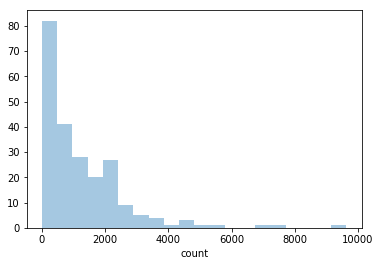

In [19]:
# plotting user
user_count = new_data.groupby('userId').count().toPandas()
sns.distplot(user_count['count'], kde = False, bins=20)

In [20]:
# checking one user
new_data.where(new_data.userId == 111).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+-----+
|Malk De Koijn;BlÃ...|Logged In|  Makayla|     F|            0|Williams|252.99546| free|Detroit-Warren-De...|   PUT|NextSong|1536372490000|      110|        Jernskjorten|   200|1538663131000|"Mozilla/5.0 (Win...|   111|false|
|         Fleet Foxes|Logged In|  Makayla|     F|            1|Williams|187.42812| free|Detroit-

It's very interesting how many sessions a user can have. :)

Let's move on to `auth`.

In [21]:
# checking auth
new_data.select('auth').distinct().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [22]:
# checking auth counts
new_data.groupBy('auth').count().show()

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+



Not an expressive ammount of `Cancelled` sessions.

In [23]:
# checking status
new_data.select('status').distinct().show()

+------+
|status|
+------+
|   307|
|   404|
|   200|
+------+



`Status` also does not look important for our analysis. 

In [24]:
# checking level
new_data.select('level').distinct().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



Since `churn` users can use free or paid accoutns, I am not sure it would be relevant.

In [25]:
# checking length
new_data.select('length').distinct().show()

+---------+
|   length|
+---------+
|200.75057|
|317.30893|
|260.28363|
|241.94567|
|262.79138|
|216.47628|
|361.66485|
|231.94077|
|375.03955|
|213.75955|
|429.16526|
|381.77914|
|347.81995|
|227.83955|
|356.20526|
|401.76281|
|387.16036|
|216.97261|
|170.97098|
|174.23628|
+---------+
only showing top 20 rows



In [26]:
# checking length
new_data.select('length').describe().show()

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



How are the `page` records? 

In [27]:
# checking pages values
(new_data.select('page').distinct().sort('page')).toPandas()

,page
0,About
1,Add Friend
2,Add to Playlist
3,Cancel
4,Cancellation Confirmation
5,Downgrade
6,Error
7,Help
8,Home
9,Logout


In [28]:
# grouping & counting pages 
page_counts = new_data.groupby('page').count().sort('count', ascending=False).toPandas().set_index('page')
page_counts

,count
page,
NextSong,228108
Thumbs Up,12551
Home,10082
Add to Playlist,6526
Add Friend,4277
Roll Advert,3933
Logout,3226
Thumbs Down,2546
Downgrade,2055


We start to see that `pages` are relevant for building a model. Specially, `Cancellation Confirmation` ones.

Better looking at it as a graphic, no?

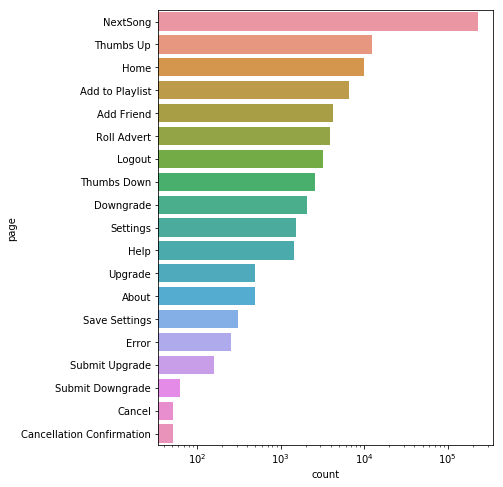

In [29]:
# plotting pages
plt.figure(figsize=(6,8))
g = sns.barplot(x = page_counts['count'], y = page_counts.index, log=True)

How would be the `timestamp` and `registration` records? 

In [30]:
# checking ts
new_data.select('ts').distinct().show()

+-------------+
|           ts|
+-------------+
|1538360520000|
|1538368903000|
|1538380099000|
|1538380879000|
|1538390386000|
|1538399222000|
|1538402692000|
|1538405492000|
|1538411816000|
|1538420258000|
|1538422643000|
|1538423103000|
|1538428266000|
|1538433192000|
|1538435390000|
|1538439836000|
|1538453678000|
|1538471202000|
|1538494626000|
|1538495500000|
+-------------+
only showing top 20 rows



In [31]:
# checking registration
new_data.select('registration').distinct().show()

+-------------+
| registration|
+-------------+
|1529027541000|
|1533192032000|
|1537779419000|
|1534627466000|
|1535389443000|
|1536642109000|
|1537167593000|
|1536854322000|
|1533908361000|
|1536817381000|
|1536663902000|
|1537672236000|
|1536956945000|
|1537611935000|
|1537751138000|
|1533532298000|
|1537057938000|
|1537964483000|
|1528772084000|
|1537440271000|
+-------------+
only showing top 20 rows



The `timestamp` and `registration` fields do not mean a lot for me in this format. Maybe would be good to change them.

In [32]:
# creating a function to convert timestamp
def convert(x):
    if x is None:
        return None
    return x//1000

In [33]:
# using convert function
convert_ts = sf.udf(convert, st.LongType())
new_data = new_data.withColumn('timestamp', convert_ts(new_data.ts).cast('timestamp'))
new_data = new_data.withColumn('registration_time', convert_ts(new_data.registration).cast('timestamp'))
new_data.select('timestamp', 'registration_time').show(5)

+-------------------+-------------------+
|          timestamp|  registration_time|
+-------------------+-------------------+
|2018-10-01 00:01:57|2018-09-28 22:22:42|
|2018-10-01 00:03:00|2018-09-30 18:20:30|
|2018-10-01 00:06:34|2018-09-28 22:22:42|
|2018-10-01 00:06:56|2018-09-30 18:20:30|
|2018-10-01 00:11:16|2018-09-28 22:22:42|
+-------------------+-------------------+
only showing top 5 rows



Muche easier to read them :)

In [34]:
# creating a plot function for day/column visualization
def time_count(df, page = None, agg = 'day', by_field = None):
    if page is not None:
        data = new_data.where(new_data.page == page)
    else:
        data = new_data
    if by_field is None:
        group = sf.date_trunc(agg, data.timestamp).alias(agg)
    elif by_field is not None:
        group = [sf.date_trunc(agg, data.timestamp).alias(agg), by_field]
    # grouping and converting to Pandas   
    day_counts = data.groupby(group).count().sort(agg).toPandas()
    # plotting
    plt.figure(figsize = (10,6))
    ax = sns.lineplot(x = agg, y = 'count', data = day_counts)
    plt.xticks(rotation = 25)

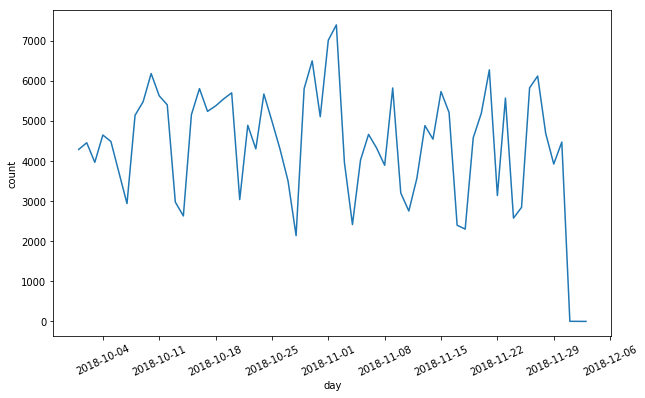

In [35]:
# plotting all data
time_count(new_data)

I really enjoy seeing the data as an image and in tnhis case we can have a better view of how users interacts with the platofrm by day.

I miss analysing one column...

In [36]:
# checking churn counts
new_data.groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
| true| 44864|
|false|233290|
+-----+------+



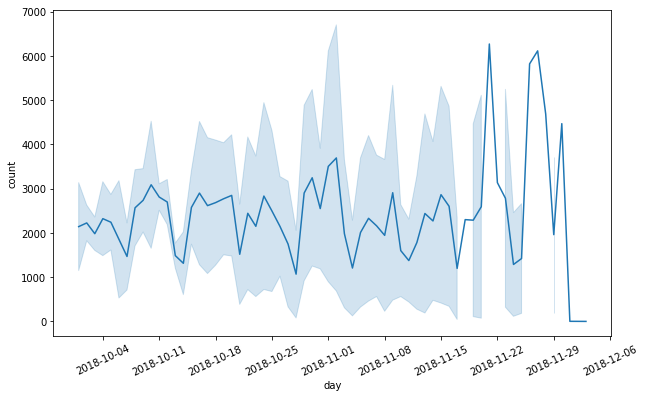

In [37]:
# plotting churn
time_count(new_data, by_field = 'churn')

Main findings:
- `Timestamp` and `registration` fields are easier to read when in a date format.
- There are null `userIds` to be cleaned.
- `Cancellation confirmation` page can point to churn users.


# Feature Engineering
Now, let's build out the features we found promising to train the model on. For this, let's
extract these features from the data set.

In [38]:
# converting timestamp
def convert(x):
    if x is None:
        return None
    
    return x//1000
convert_ts = sf.udf(convert, st.LongType())

In [39]:
# cleaning data set
def clean(data):
    data = data.filter(data.userId != "")
    data.persist()
    return data

In [40]:
def featuring_data(data):
    # defining columns in vector
    vec_cols = []
    # session counts
    sessions = data.groupby('userId').agg(sf.countDistinct('sessionId').alias('sessions'))
    vec_cols.append('sessions')
    # event counts
    data = data.groupby('userId').pivot('page').count()
    data = data.withColumnRenamed('Cancellation Confirmation', 'label')
    data = data.drop(*['Cancel']).fillna(0)
    data = data.join(sessions, on = 'userId')
    # normalizing
    no_cols = {'userId', 'sessions', 'label'}
    yes_cols = sorted(list(set(data.columns) - no_cols))
    for column in yes_cols:
        data = data.withColumn(column, sf.col(column) / data.sessions)
    vec_cols.extend(yes_cols)
    # assemble the vector
    assembler = VectorAssembler(inputCols = vec_cols, outputCol = 'features')
    # returning data
    return assembler.transform(data)

In [41]:
# featuring the data
feature_data = featuring_data(data)
# counting feaures
feature_data.select('features').count()

226

In [42]:
# printing columns
feature_data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- About: double (nullable = true)
 |-- Add Friend: double (nullable = true)
 |-- Add to Playlist: double (nullable = true)
 |-- label: long (nullable = true)
 |-- Downgrade: double (nullable = true)
 |-- Error: double (nullable = true)
 |-- Help: double (nullable = true)
 |-- Home: double (nullable = true)
 |-- Login: double (nullable = true)
 |-- Logout: double (nullable = true)
 |-- NextSong: double (nullable = true)
 |-- Register: double (nullable = true)
 |-- Roll Advert: double (nullable = true)
 |-- Save Settings: double (nullable = true)
 |-- Settings: double (nullable = true)
 |-- Submit Downgrade: double (nullable = true)
 |-- Submit Registration: double (nullable = true)
 |-- Submit Upgrade: double (nullable = true)
 |-- Thumbs Down: double (nullable = true)
 |-- Thumbs Up: double (nullable = true)
 |-- Upgrade: double (nullable = true)
 |-- sessions: long (nullable = false)
 |-- features: vector (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

**logistic regression**

I choose **Logistic Regression** as one of the models because it is used to describe data and to explain the relationship between one dependent binary variable and one or more nominal.

In [43]:
# defining test and train datasets
train, test = feature_data.randomSplit([0.8, 0.2], seed=42)

In [44]:
# using logistic regression
log_reg =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

In [45]:
# model: fitting train data
lg_model = log_reg.fit(train)

In [46]:
# testing model
lg_results = lg_model.transform(test)

**Metrics**

Besides `accuracy` I also want to calculate `F-Score`. The F-Score measures of the accuracy and better provides a realistic performance by using `precision` and `recall`. 

In [47]:
# calculating metrics
def metrics(df):
    total = df.count()
    tp = df.where((df.label==1) & (df.prediction==1)).count()
    tn = df.where((df.label==0) & (df.prediction==0)).count()
    fp = df.where((df.label==0) & (df.prediction==1)).count()
    fn = df.where((df.label==1) & (df.prediction==0)).count()
    # defining     
    accuracy = (1.0 * tp + tn) / total
    precision = 1.0 * tp / (tp + fp)
    recall = 1.0 * tp / (tp + fn)
    f1 = 2.0 * (precision * recall) / (precision + recall)
    # printing
    print('Accuracy: ', round(accuracy, 2))
    print('Precision: ', round(precision, 2))
    print('Recall: ', round(recall, 2))
    print('F1-Score: ', round(f1, 2))

In [48]:
# calculating metrics for logistic model
metrics(lg_results)

Accuracy:  0.71
Precision:  0.25
Recall:  0.12
F1-Score:  0.17


**random forest**

My second choice is **Random Forest**. It builds multiple decision trees and merges them together to get a more accurate and stable prediction. 

In [49]:
# using random forest
ran_for = RandomForestClassifier()
rf_model = ran_for.fit(train)
rf_results = rf_model.transform(test)

In [50]:
# calculating metrics
def metrics(df):
    total = df.count()
    tp = df.where((df.label==1) & (df.prediction==1)).count()
    tn = df.where((df.label==0) & (df.prediction==0)).count()
    fp = df.where((df.label==0) & (df.prediction==1)).count()
    fn = df.where((df.label==1) & (df.prediction==0)).count()
    # defining     
    accuracy = (1.0*tp + tn) / total
    # printing
    print('Accuracy: ', round(accuracy, 2))

In [51]:
# getting results
metrics(rf_results)

Accuracy:  0.76


**Improvements**

- Changing minimun of instances per node and number of trees
- Using cross validator

In [52]:
# changing parameters
paramGrid_rf = ParamGridBuilder() \
                .addGrid(ran_for.minInstancesPerNode, [2, 5]) \
                .addGrid(ran_for.numTrees, [25, 35]) \
                .addGrid(ran_for.maxDepth, [9, 11]) \
                .build()

In [53]:
# using cross validator
cross_validator = CrossValidator(estimator = ran_for,
                             estimatorParamMaps = paramGrid_rf,
                             numFolds = 5,
                             evaluator = BinaryClassificationEvaluator())

In [54]:
# training and testing - takes very long time to run
cross_model = cross_validator.fit(train)
cross_results = cross_model.transform(test)

In [55]:
# getting results
metrics(cross_results)

Accuracy:  0.76


In [56]:
# getting avg metrics
cross_model.avgMetrics

[0.612439438416668,
 0.6103851683491152,
 0.5626129642372527,
 0.5651690727573082,
 0.6169719447746014,
 0.6169719447746014,
 0.5848274063416379,
 0.5848274063416379]

**Conclusions**

Using **PySpark** was a great challenge!

After cleaning, exploring and identifying target features in the data, the `random forest` model performed better than the `logistic regression` for the `mini_sparkify_event_data`. Once applying cross validator and improvements in the model, I got accuracy of 76% for `random forest`.


**References**
- StakOverFlow https://stackoverflow.com/
- Databricks https://docs.databricks.com
- Apache Spark https://spark.apache.org/
- DeepAI https://deepai.org/machine-learning-glossary-and-terms/f-score